# Herval Deep Mailing

Esse modulo cria um dataframe do tipo pandas que contem todas as colunas normalizadas, ou seja, valores transpostos entre 0.0 e 1.0. Importante notar que a entrada dessa operacao eh uma planilha em excel, que deve ter as seguintes colunas:
    
* CPF: Valor String
* CLIENTE_VALOR_DIVIDA: Valor Numerico (** Obrigatorio **)
* CONTRATO_ATRASO: Valor Numerico (** Obrigatorio **)
* RENDA_PRESUMIDA: Valor Numerico (** Nao eh Obrigatorio **)
* ESCOLARIDADE: Valor Numerico (** Nao eh Obrigatorio **)
* CLASSE_SOCIAL: Valor Numerico (** Nao eh Obrigatorio **)
    
No caso de ser um excel para treinamento de modelos eh necessario tambem informar a coluna PAGOU que tera o valor 0 ou 1, e eh a variavel alvo a ser usada.    



Importacao dos modulos necessarios

In [1]:
import pandas as pd
import dateutil.parser as parser
import os.path
import math
import logging
import numpy as np
from multiprocessing import Pool
from datetime import datetime
import gc
import pickle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
log_location = "../../logs/"
arquivo_fonte = "../../data/batch03/inputs/herval_final.xls"
arquivo_saida = "../../data/batch03/intermediate/Herval.normalized.pickle"
cluster_imagem = "../../data/batch03/intermediate/cluster.png"

pd.options.display.max_columns = 150
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('display.expand_frame_repr', False)

Configuracao do log a ser usado no processo e funcao para imprimir tanto na tela quanto no log abaixo

In [3]:
logger = logging.getLogger()
logger.handlers = []
logger = logging.getLogger(__name__)
logging.basicConfig(format="%(asctime)-15s %(message)s",
                    level=logging.DEBUG,
                    filename=os.path.join(log_location,'prepare_data.log.' + \
                                          datetime.now().strftime("%Y%m%d%H%M%S.%f") + '.log'))
def print_log(x):
    logging.debug(x)
    print(x)

Funcao para limpar o dataframe de qualquer coluna desnecessario

In [4]:
def limpar_df(pagantes):
    return pagantes

Funcoes de limpeza de string para os tratamentos abaixo

In [5]:
def func_str(x):
    return str(x).replace(" ","_").upper().strip()

def func_strip(x):
    return str(x).strip()

def func_start_ALTA(x):
    return str(x).startswith('ALTA')

Conversoes e funcoes para tratamento de coluna

In [6]:
def ConverterPAGOU(x):
    return 1 if x == 1 else 0
def ConverterSimNao(x):
    return 1 if x == "Sim" else 0
def print_colunas(df):
    for coluna in pagantes.head(10).columns.values:
        print_log(coluna)    

Dictionary que define quais sao as funcoes a serem executadas quando carregamos o dataframe

In [7]:
converters = { 
    "ESCOLARIDADE" : func_str
}
df_dtypes = {}

Le o excel passando  os tipos e conversores a serem usados em cada coluna

In [8]:
pagantes = pd.read_excel(arquivo_fonte, dtype=df_dtypes, converters = converters)
print_log("CSV carregado, limpando colunas desnecessarias")
print_colunas(pagantes)

CSV carregado, limpando colunas desnecessarias
CPF
CLIENTE_VALOR_DIVIDA
PAGOU
CONTRATO_ATRASO
RENDA_ESTIMADA
RENDA_PRESUMIDA
ESCOLARIDADE
CLASSE_SOCIAL


Limpamos o dataframe de colunas indesejadas

In [9]:
pagantes = limpar_df(pagantes)
print_log("-------------------------------------------")
print_log("Colunas Remanescentes...")
print_log("-------------------------------------------")
print_colunas(pagantes)

-------------------------------------------
Colunas Remanescentes...
-------------------------------------------
CPF
CLIENTE_VALOR_DIVIDA
PAGOU
CONTRATO_ATRASO
RENDA_ESTIMADA
RENDA_PRESUMIDA
ESCOLARIDADE
CLASSE_SOCIAL


Removendo todos os casos que CLIENTE_VALOR_DIVIDA e CONTRATO_ATRASO sao nulos (ou seja, np.nan) e apos resetando o indice interno

In [10]:
pagantes = pagantes[np.isfinite(pagantes['CLIENTE_VALOR_DIVIDA'])]
pagantes = pagantes[np.isfinite(pagantes['CONTRATO_ATRASO'])]
pagantes = pagantes.reset_index()
#print_log(pagantes.head(10))

## Clusterizacao

Agora precisamos criar um array de numpy com todos os dados de CLIENTE_VALOR_DIVIDA e CONTRATO_ATRASO de forma que possamos dai gerar uma clusterizacao para melhorar a precisao dos dados

In [11]:
valores_pagantes_para_cluster = pagantes[['CLIENTE_VALOR_DIVIDA','CONTRATO_ATRASO']]
np_valores_pagantes_para_cluster = valores_pagantes_para_cluster.as_matrix()

Com um numpy array com os dados de CLIENTE_VALOR_DIVIDA e CONTRATO_ATRASO podemos entao criar um cluster com 4 segmentacoes para melhorar a precisao do algoritmo, o id do cluster que sera determinado para cada linha do dataframe sera colocado na coluna CLUSTER do dataframe

In [12]:
kmeans_pagantes = KMeans(n_clusters=4, random_state=0).fit(np_valores_pagantes_para_cluster)
clusters = kmeans_pagantes.predict(np_valores_pagantes_para_cluster)
pagantes['CLUSTER'] = pagantes.apply(lambda row: clusters[row.name] , axis=1)

Para visualizacao e depuracao, criamos uma figura para salvar o PNG e ver direitinho como ficou...

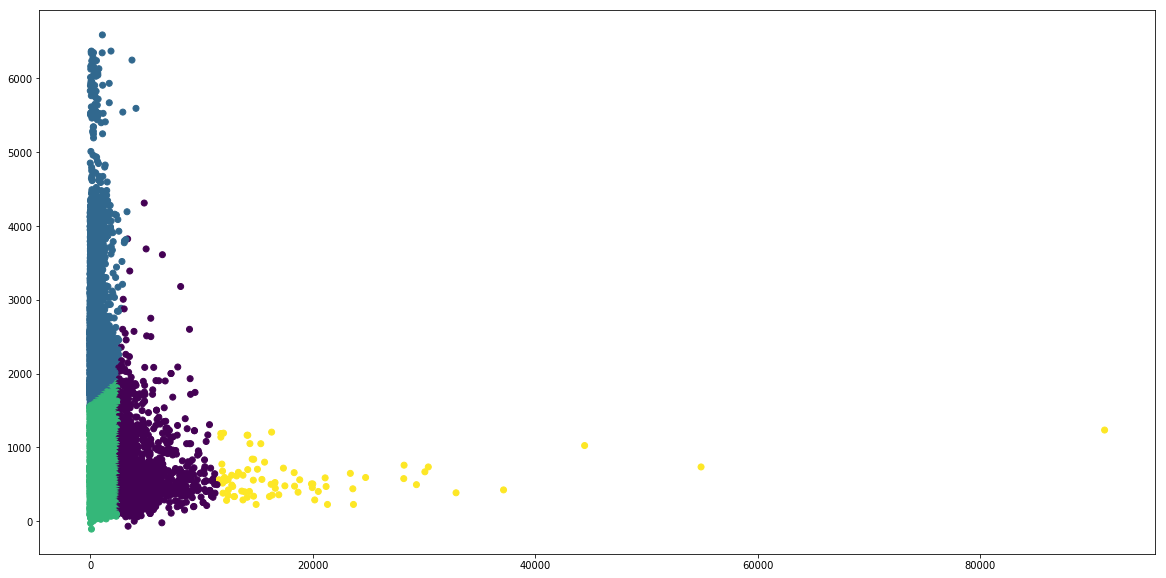

In [13]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.scatter(np_valores_pagantes_para_cluster[:,0], np_valores_pagantes_para_cluster[:,1], c=clusters)
plt.savefig(cluster_imagem)
plt.show()

## Normalizacao dos Dados e Tratamento dos Dados

Funcoes especiais para parsear dados que vem em formato de string

In [14]:
def ParseNumTelefone(x):
    ret = np.nan
    if str(x).startswith('['):
        ret = x[1:]
        ret = ret.split(';')[0]
        ret = ret[0:2]
    return ret

def ParseRendaEstimada(x):
    ret = np.nan
    if str(x) == 'SEM INFORMACAO':
        return ret
    if len(str(x)) > 4:
        ret = str(x)
        ret = ret.replace('DE ',' ').replace(' A ', ' ').replace('SEM INFORMACAO', ' ').replace('ACIMA ', ' ').replace(',01',' ').replace('.','').replace('ATE ',' ')
        ret = ret.replace('  ',' ')
        ret = ret.strip()
        ret = ret.split(' ')[0]
        ret = int(ret)
    return ret

As funcoes abaixo normalizam as colunas com valores continuos para um espaco de 0 a 1. e para valores discretos eh criada uma coluna a mais com o valor de 0 ou 1, no sentido do valor estar presente ou nao.

In [15]:
# Cria uma coluna para cada valor discreto daquela coluna, e atribui 1 ou 0 a essa coluna.
def CreateColumnStr(cols, df, source_col):
    for col in cols:
        if str(col) == "nan":
            continue
        df['NORM_' + source_col + "_" + str(col)] = df.apply(lambda row: 1 if func_str(row[source_col]) == func_str(col) else 0, axis=1)
    return df

# Em colunas com valores sequenciais, trunca o valor de cada coluna no maximo e no minimo
def RemoveOutliers(df, source_col, min, max):
    df['NORM_' + source_col] = df.apply(lambda row: 0   if row[source_col] < min else row[source_col] , axis=1)
    df['NORM_' + source_col] = df.apply(lambda row: max if row[source_col] > max else row[source_col] , axis=1)
    return df

# Cria uma proporcao em termos de 0.0 a 1.0 em valores sequenciais, usando como o valor maximo: (media + (4*desvio_padrao))
def CreateProportion(df, source_col):
    max = df[source_col].mean() + (df[source_col].std() * 4 )
    min = 0
    
    df = RemoveOutliers(df, source_col, min, max)
    print_log("({}) - Valores entre {} e {}".format(source_col, min, max))
   
    df['NORM_' + source_col] = df.apply(lambda row: 0 if row['NORM_' + source_col] == 0 else ((row['NORM_' + source_col] - min) / max) , axis=1)
    return df

#Cria colunas de telefone a partir do parse da string
def CreateNumeroTelefone(df,source_col):
    df['PARSED_' + source_col] = df.apply(lambda row: ParseNumTelefone(row[source_col]) , axis=1)
    return df

#Cria colunas de Renda Estimada a partir do parsing do texto da renda estimada
def CreateRendaEstimada(df,source_col):
    df['PARSED_' + source_col] = df.apply(lambda row: ParseRendaEstimada(row[source_col]) , axis=1)
    return df

Caso exista a coluna PAGOU no dataframe, entao normaliza ela...

In [16]:
if 'PAGOU' in pagantes.head(10).columns.values:
    pagantes['PAGOU'] = pagantes.apply(lambda row: 1 if row['PAGOU'] == 1 else 0, axis=1)

Chama as funcoes acima para criar as colunas normalizadas com valores entre 0 a 1

In [17]:
pagantes = CreateProportion(pagantes, 'CLIENTE_VALOR_DIVIDA')
pagantes = CreateProportion(pagantes, 'CONTRATO_ATRASO')
pagantes = CreateProportion(pagantes, 'RENDA_PRESUMIDA')
pagantes = CreateColumnStr(pagantes['ESCOLARIDADE'].unique(), pagantes, 'ESCOLARIDADE')
pagantes = CreateColumnStr(pagantes['CLASSE_SOCIAL'].unique(), pagantes, 'CLASSE_SOCIAL')

(CLIENTE_VALOR_DIVIDA) - Valores entre 0 e 6564.626638893511
(CONTRATO_ATRASO) - Valores entre 0 e 5348.158967223659
(RENDA_PRESUMIDA) - Valores entre 0 e 10313.507152378841


Agora temos um dataframe com varias colunas, precisamos entao apenas selecionar as colunas que necessitamos manter no dataframe

In [18]:
colunas_para_processar = []
if 'PAGOU' in pagantes.head(10).columns.values:
   colunas_para_processar.append('PAGOU')
if 'CLUSTER' in pagantes.head(10).columns.values:
   colunas_para_processar.append('CLUSTER')
if 'CPF' in pagantes.head(10).columns.values:
   colunas_para_processar.append('CPF')

for coluna in pagantes.head(10).columns.values:
    if not coluna.startswith('NORM_'):
        continue
    colunas_para_processar.append(coluna)
colunas_para_processar = sorted(list(set(colunas_para_processar)))

Uma vez com as colunas selecionadas, podemos criar um dataframe apenas com elas e remover todas as linhas invalidas q tenham qualquer valor nulo.

In [19]:
pagantes = pagantes[colunas_para_processar]
pagantes = pagantes.dropna(axis = 0, how="any")

Gravamos o arquivo final normalizado

In [20]:
pagantes.to_pickle(arquivo_saida)